## Analyze the export on hpatches - detector

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/yoyee/Documents/deepSfm


In [2]:
# folders
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from imageio import imread
def load_as_float(path):
    return imread(path).astype(np.float32)/255

# folders = ['superpoint_pretrained_hpatches', 'superpoint_coco20_8_170k_hpatches', \
#            'magicpoint_coco_new1_10k_hpatches']
# folders = ['superpoint_coco2_3_hpatches-a3']
folders = ['superpoint_coco40_16_170k_hpatches_nms4_det0.015']
# folders = ['subp32_syn1_0_100k_hpatches']
# folders = ['subp32_syn1_0_100k_hpatches']
# folders = ['superpoint_pretrained_hpatches', 'superpoint_coco20_5_50k_hpatches']

# parameters
scale = 10
count = 1

base_path = '../logs'
prediction = 'predictions'


In [3]:
import torch
def getLabels(points_path, img_shape):
    pnts = np.load(points_path)['pts']
    pnts = pnts.astype(int)
    labels = np.zeros((img_shape[0], img_shape[1]))
    labels[pnts[:, 1], pnts[:, 0]] = 1
    labels_2D = torch.tensor(labels[np.newaxis,:,:], dtype=torch.float32)
    return labels_2D, pnts

def pnts2img(pnts, img_shape):
    pnts = pnts.astype(int)
    labels = np.zeros((img_shape[0], img_shape[1]))
    labels[pnts[:, 0], pnts[:, 1]] = 1  # pnts (y,x)
    labels_2D = torch.tensor(labels[np.newaxis,:,:], dtype=torch.float32)
    return labels_2D, pnts

def warpLabels(pnts, homography, H, W):
    """
    input: 
        pnts: numpy
        homography: numpy
    output:
        warped_pnts: numpy
    """
    from utils.utils import warp_points
    from utils.utils import filter_points
    pnts = torch.tensor(pnts).long()
    homography = torch.tensor(homography, dtype=torch.float32)
    warped_pnts = warp_points(torch.stack((pnts[:, 0], pnts[:, 1]), dim=1),
                                   homography) # check the (x, y)
    warped_pnts = filter_points(warped_pnts, torch.tensor([W, H])).round().long()
    return warped_pnts.numpy()

def img_overlap(img_r, img_g, img_gray):  # img_b repeat
    img = np.concatenate((img_gray, img_gray, img_gray), axis=0)
    img[0, :, :] += img_r[0, :, :]
    img[1, :, :] += img_g[0, :, :]
    img[img > 1] = 1
    img[img < 0] = 0
    img = img.transpose([1,2,0])

    return img

def printImgPnts(image, pnts):
    img_shape = image.shape

    print(img_shape)
    labels_2D, pnts = pnts2img(keypoints, img_shape)
    labels_2D = labels_2D.squeeze().numpy()
    print("labels ", labels_2D.shape)

    img_r = np.zeros_like(image)
    overlap = img_overlap(img_r[np.newaxis,:,:], 
                          labels_2D[np.newaxis,:,:], image[np.newaxis,:,:])
    print(overlap.shape)
    plt.imshow(overlap)
    plt.show()

In [4]:
def getNumPoints(data, verbose=False):
    # read data
    image = data['image']
    warped_image = data['warped_image']
    real_H = data['homography']
    keypoints = data['prob'][:,[1, 0]] # (y, x)
    desc = data['desc']
    warped_keypoints = data['warped_prob'][:,[1, 0]]
    if verbose:
        print("keypoints shape: ", keypoints.shape)
        print("desc shape: ", desc.shape)
    
    # unwarp points, filter
    from numpy.linalg import inv
    H, W = image.shape
    unwarped_keypoints = warpLabels(warped_keypoints, inv(real_H), H, W)
    
    # return number of points
    ## average the points in 2 images
    return [keypoints.shape[0], warped_keypoints.shape[0], unwarped_keypoints.shape[0], 
            (keypoints.shape[0]+unwarped_keypoints.shape[0])/2]

### repeatibility

In [5]:
def select_k_best(points, k, thresh=0, verbose=False):
    """ Select the k most probable points (and strip their proba).
    points has shape (num_points, 3) where the last coordinate is the proba. """
    sorted_prob = points
    if points.shape[1] > 2:
        # add thresh
        if verbose: print('num of points: ', points.shape)

        sorted_prob = points[points[:,2] > thresh, :]
        if verbose: print('num of points after thresh: ', sorted_prob.shape)

#             sorted_prob = points[points[:, 2].argsort(), :]
        sorted_prob = sorted_prob[sorted_prob[:, 2].argsort(), :]

        start = min(k, points.shape[0])
        sorted_prob = sorted_prob[-start:, :]
    return sorted_prob

In [6]:
# from evaluations.detector_evaluation import compute_repeatability
def compute_repeatability(data, keep_k_points=300,
                          distance_thresh=3, detection_threshold=0, verbose=False):
    """
    Compute the repeatability. The experiment must contain in its output the prediction
    on 2 images, an original image and a warped version of it, plus the homography
    linking the 2 images.
    """
    from evaluations.detector_evaluation import warp_keypoints
    
    def filter_keypoints(points, shape):
        """ Keep only the points whose coordinates are
        inside the dimensions of shape. """
        """
        points:
            numpy (N, (x,y))
        shape:
            (y, x)
        """
        mask = (points[:, 0] >= 0) & (points[:, 0] < shape[1]) &\
               (points[:, 1] >= 0) & (points[:, 1] < shape[0])
        return points[mask, :]

    def keep_true_keypoints(points, H, shape):
        """ Keep only the points whose warped coordinates by H
        are still inside shape. """
        """
        input:
            points: numpy (N, (x,y))
            shape: (y, x)
        return:
            points: numpy (N, (x,y))
        """
        # warped_points = warp_keypoints(points[:, [1, 0]], H)
        warped_points = warp_keypoints(points[:, [0, 1]], H)
        # warped_points[:, [0, 1]] = warped_points[:, [1, 0]]
        mask = (warped_points[:, 0] >= 0) & (warped_points[:, 0] < shape[1]) &\
               (warped_points[:, 1] >= 0) & (warped_points[:, 1] < shape[0])
        return points[mask, :]

    # paths = get_paths(exper_name)
    localization_err = -1
    repeatability = []
    N1s = []
    N2s = []
    # for path in paths:
    # data = np.load(path)
    shape = data['image'].shape
    H = data['homography']

    # Filter out predictions
    keypoints = data['prob']
    # warped_keypoints = data['warped_prob'][:, :2]
    warped_keypoints = data['warped_prob']
    warped_keypoints = keep_true_keypoints(warped_keypoints, np.linalg.inv(H),
                                           data['image'].shape)

    # Warp the original keypoints with the true homography
    true_warped_keypoints = keypoints
    # true_warped_keypoints[:,:2] = warp_keypoints(keypoints[:, [1, 0]], H)
    true_warped_keypoints[:,:2] = warp_keypoints(keypoints[:, :2], H) # make sure the input fits the (x,y)
    # true_warped_keypoints = np.stack([true_warped_keypoints[:, 1],
    #                                   true_warped_keypoints[:, 0],
    #                                   prob], axis=-1)
    true_warped_keypoints = filter_keypoints(true_warped_keypoints, shape)

    # Keep only the keep_k_points best predictions
    warped_keypoints = select_k_best(warped_keypoints, keep_k_points, 
                                     thresh=detection_threshold, verbose=verbose)
    true_warped_keypoints = select_k_best(true_warped_keypoints, keep_k_points, 
                                     thresh=detection_threshold, verbose=verbose)

    # Compute the repeatability
    N1 = true_warped_keypoints.shape[0]
    N2 = warped_keypoints.shape[0]
    N1s.append(N1)
    N2s.append(N2)
    true_warped_keypoints = np.expand_dims(true_warped_keypoints, 1)
    warped_keypoints = np.expand_dims(warped_keypoints, 0)
    # shapes are broadcasted to N1 x N2 x 2:
    norm = np.linalg.norm(true_warped_keypoints - warped_keypoints,
                          ord=None, axis=2)
    count1 = 0
    count2 = 0
    local_err1, local_err2 = None, None
    if N2 != 0:
        min1 = np.min(norm, axis=1)
        count1 = np.sum(min1 <= distance_thresh)
        local_err1 = min1[min1 <= distance_thresh]
#         print("count1: ", count1.shape)
#         print("local_err1: ", local_err1)        
    if N1 != 0:
        min2 = np.min(norm, axis=0)
        count2 = np.sum(min2 <= distance_thresh)
        local_err2 = min2[min2 <= distance_thresh]

    if N1 + N2 > 0:
        # repeatability.append((count1 + count2) / (N1 + N2))
        repeatability = (count1 + count2) / (N1 + N2)
    if count1 + count2 > 0:
        localization_err = 0
        if local_err1 is not None:
            localization_err += (local_err1.sum())/ (count1 + count2)
        if local_err2 is not None:
            localization_err += (local_err2.sum())/ (count1 + count2)
    else:
        repeatability = 0
    if verbose:
        print("Average number of points in the first image: " + str(np.mean(N1s)))
        print("Average number of points in the second image: " + str(np.mean(N2s)))
    # return np.mean(repeatability)
    return repeatability, localization_err


In [7]:
def visualize_points(data, thresh=0, verbose=False):
    from utils.draw import draw_keypoints
    from utils.utils import saveImg
    img_2D = data['image']
    if verbose: print("img_2D max: ", img_2D.max())
    for t in thresh:
        pts = data['prob']
        pts = select_k_best(pts, k=1000, 
                thresh=t, verbose=verbose)

        img_pts = draw_keypoints(img_2D * 255, pts.transpose())
        if verbose: print("img_pts: ", img_pts.shape)
        plt.imshow(img_pts/255)
        plt.show()
    
    

(0,)
rep_all:  [0.264305   0.264305   0.264305   0.264305   0.264305   0.264305
 0.26504746 0.26540252 0.26665658 0.2681864  0.26970865 0.27227083
 0.274579   0.27643696 0.27772441 0.2788896  0.27953152 0.28015486
 0.27978154 0.27857416]


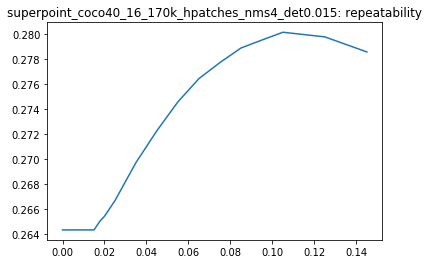

In [8]:
# images_num = 10
# rows = images_num
# cols = len(folders)
# plt.figure(figsize=(cols*2*scale, rows*scale))
# task_folder = ['repeatibility3']
count = 1
max_iter = 600
verbose = False
rep_thd = 1
rep_thd = np.array(rep_thd)[...,np.newaxis]
det_thd = [0, 0.003, 0.006, 0.009, 0.012, 0.015, 0.018, 0.02, 0.025, 0.030, 0.035, 
           0.045, 0.055, 0.065, 0.075, 0.085, 0.095, 0.105, 0.125, 0.145]
# det_thd = [0.012, 0.015]
rep_all = []
plot_images = False
if verbose: print("rep_thd: ", rep_thd)
if verbose: print("det_thd: ", det_thd)

all_num_points = []
for folder in folders:
    num_points = [] # [[keypoints, warped_keypoints, unwarped_keypoints]]
    exp_path = Path(base_path, folder, prediction)
    files = os.listdir( exp_path )
#     for f in files:
    for f in files:
    #     print("file: ", f)
        if count > max_iter:
            break
        if f[-3:] == 'npz':
            if verbose: print("file: ", f)
            data = np.load(exp_path/f)
            if verbose: print(list(data))
            reps = []
            for t in det_thd:
                if verbose: print("det thd: ", t)
                rep, local_err = compute_repeatability(data, keep_k_points=300, 
                                                       distance_thresh=rep_thd, detection_threshold=t, 
                                                       verbose=verbose)
                reps.append(rep)
            rep_all.append(reps)
            
            # plot images
            if plot_images:
                visualize_points(data, thresh=det_thd, verbose=True)
            
#             print("reps: ", reps)
#             num_points.append(getNumPoints(data))
    #         print("points: ", getNumPoints(data))
            count += 1
    # file =  exp_path / '0.npz'

    num_points = np.array(num_points)
    print(num_points.shape)
    all_num_points.append(num_points)

    rep_all = np.array(rep_all)
    print('rep_all: ', rep_all.mean(axis=0))
    
    plt.plot(det_thd, rep_all.mean(axis=0))
    plt.title(folder + ": repeatability")
    plt.show()